In [4]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from skimage.segmentation import slic, mark_boundaries
from torchvision import transforms, models

In [5]:
############################################
# 1) Load ImageNet Labels from a Local File
############################################
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

############################################
# 2) Set Device (GPU if available)
############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############################################
# 3) Utility Function: Load an Image from a URL
############################################
def load_image_from_url(url):
    response = requests.get(url)
    pil_img = Image.open(BytesIO(response.content)).convert("RGB")
    return pil_img


In [6]:
# 4) Superpixel Segmentation using SLIC
############################################
def segment_image(image, n_segments=50):
    # Use start_label=0 so that superpixel labels are 0-indexed.
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, start_label=0)
    return segments

In [7]:
# 5) Perturbation Function: Hide Superpixels
############################################
def perturb_image(image, segments, binary_mask, hide_color=None):
    if hide_color is None:
        # Use the global average color if no hide_color is provided.
        hide_color = np.mean(image, axis=(0, 1)).astype(image.dtype)
    perturbed = image.copy()
    for seg_val in np.unique(segments):
        if binary_mask[int(seg_val)] == 0:
            perturbed[segments == seg_val] = hide_color
    return perturbed

In [8]:
# 6) Generate Perturbed Samples (Binary Masks)
############################################
def generate_perturbed_samples(num_segments, num_samples=1000, random_state=None):
    rng = np.random.RandomState(random_state)
    samples = []
    # The original image: all superpixels present.
    samples.append(np.ones(num_segments, dtype=int))
    for _ in range(num_samples - 1):
        sample = rng.binomial(1, 0.5, size=num_segments)
        samples.append(sample)
    return np.array(samples)

In [9]:
# 7) Compute Kernel Weights Based on Perturbation Distance
############################################
def compute_kernel_distance(binary_samples, sigma=0.25):
    num_segments = binary_samples.shape[1]
    # Compute the fraction of superpixels turned off.
    distances = (num_segments - np.sum(binary_samples, axis=1)) / num_segments
    weights = np.exp(- (distances ** 2) / (sigma ** 2))
    return weights


In [10]:
# 8) Batch Prediction Function
############################################
def batch_predict(images, model, transform):
    model.eval()
    tensors = []
    for img in images:
        pil_img = Image.fromarray(img.astype("uint8"))
        tensor = transform(pil_img)
        tensors.append(tensor)
    batch = torch.stack(tensors).to(device)
    with torch.no_grad():
        logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [11]:
# 9) Weighted Linear Regression Function
############################################
def weighted_linear_regression(X, y, sample_weights):
    n, d = X.shape
    # Create a design matrix with an intercept column.
    X_design = np.concatenate([np.ones((n, 1)), X], axis=1)
    W = np.diag(sample_weights)
    A = X_design.T @ W @ X_design
    b = X_design.T @ (sample_weights * y)
    coef = np.linalg.solve(A, b)
    return coef  # coef[0] is the intercept; remaining are feature weights.


In [12]:
# 10) Create an Explanation Mask from Feature Weights
############################################
def get_explanation_mask(segments, feature_weights, num_features=5):
    # Pick the indices of the top 'num_features' superpixels.
    top_indices = np.argsort(feature_weights)[-num_features:]
    mask = np.zeros_like(segments, dtype=bool)
    for i in top_indices:
        mask[segments == i] = True
    return mask

In [13]:
# 11) Get Top-k Predictions for an Image
############################################
def get_topk_predictions(image_np, model, transform, k=3):
    tensor = transform(Image.fromarray(image_np)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
    topk = torch.topk(probs, k)
    top_indices = topk.indices.cpu().numpy()
    top_probs = topk.values.cpu().numpy()
    results = []
    for idx, p in zip(top_indices, top_probs):
        results.append((classes[idx], float(p), idx))
    return results


In [14]:
# 12) LIME-like Explanation for a Specific Class
############################################
def explain_instance_for_class(image, model, transform, class_index,
                               num_samples=1000, sigma=0.25, n_segments=50,
                               random_state=42, num_features=10):
    segments = segment_image(image, n_segments=n_segments)
    num_segments_actual = len(np.unique(segments))
    binary_samples = generate_perturbed_samples(num_segments_actual, num_samples, random_state)
    perturbed_images = []
    for bin_mask in binary_samples:
        perturbed = perturb_image(image, segments, bin_mask)
        perturbed_images.append(perturbed)
    perturbed_images = np.array(perturbed_images)
    preds = batch_predict(perturbed_images, model, transform)
    target_preds = preds[:, class_index]
    weights = compute_kernel_distance(binary_samples, sigma)
    coef = weighted_linear_regression(binary_samples, target_preds, weights)
    intercept = coef[0]
    feature_weights = coef[1:]
    explanation_mask = get_explanation_mask(segments, feature_weights, num_features)
    return explanation_mask, feature_weights

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\장재훈/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 25.9MB/s] 


Top-3 Predictions:
  collie (0.19)
  papillon (0.14)
  Shetland sheepdog (0.08)


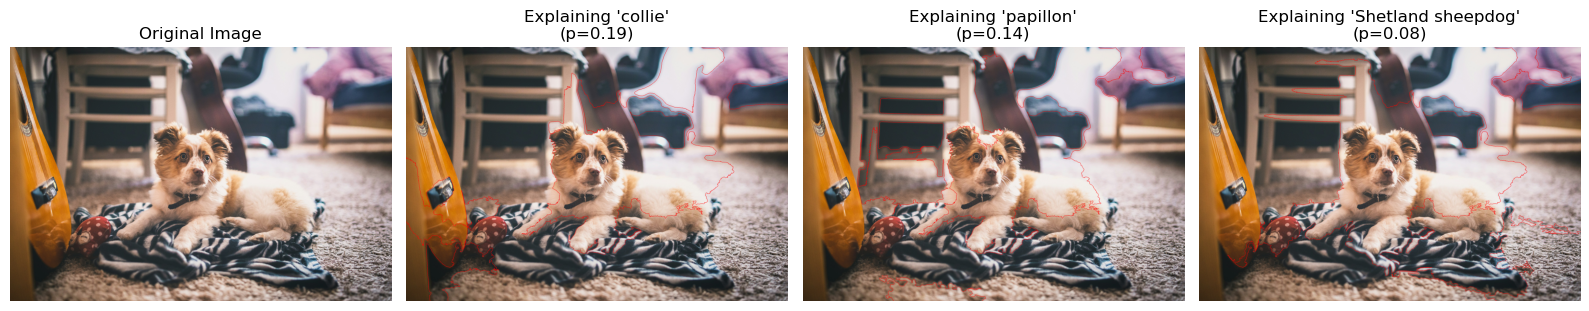

In [15]:
# 13) Putting It All Together Using Inception v3
############################################
# Load the pretrained Inception v3 model (with weights from torchvision)
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.to(device)
model.eval()

# Inception v3 expects 299x299 images.
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# Use an Unsplash direct download URL for a "dog with a guitar"–like image.
# Here we use a direct download link for a photo of a short-coated fawn and white puppy beside a guitar inside a room.
image_url = "https://unsplash.com/photos/ux3Tc-eDLcI/download?force=true"
dog_guitar_pil = load_image_from_url(image_url)
dog_guitar_np = np.array(dog_guitar_pil)

# (A) Get the top-3 predictions for the image.
top3 = get_topk_predictions(dog_guitar_np, model, transform, k=3)
print("Top-3 Predictions:")
for label, prob, idx in top3:
    print(f"  {label} ({prob:.2f})")

# (B) For each top predicted class, generate an explanation mask.
explanation_masks = []
for label, prob, idx in top3:
    mask, feat_w = explain_instance_for_class(
        dog_guitar_np, model, transform, class_index=idx,
        num_samples=1000, sigma=0.25, n_segments=50, random_state=42, num_features=10
    )
    explanation_masks.append((label, prob, idx, mask))

# (C) Visualize: one plot for the original image plus one plot for each explanation.
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(dog_guitar_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, (label, prob, idx, mask) in enumerate(explanation_masks, start=1):
    overlay = mark_boundaries(dog_guitar_np, mask.astype(int), color=(1, 0, 0), mode='thick')
    axes[i].imshow(overlay)
    axes[i].set_title(f"Explaining '{label}'\n(p={prob:.2f})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


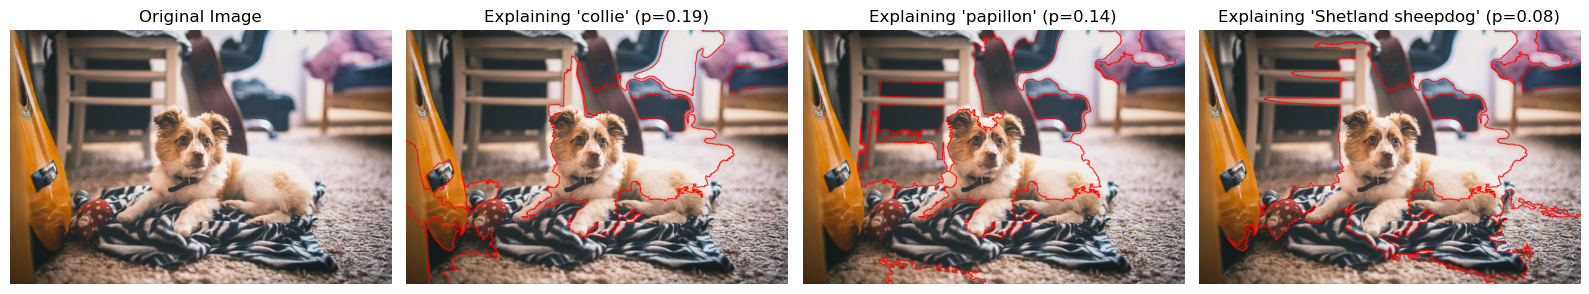

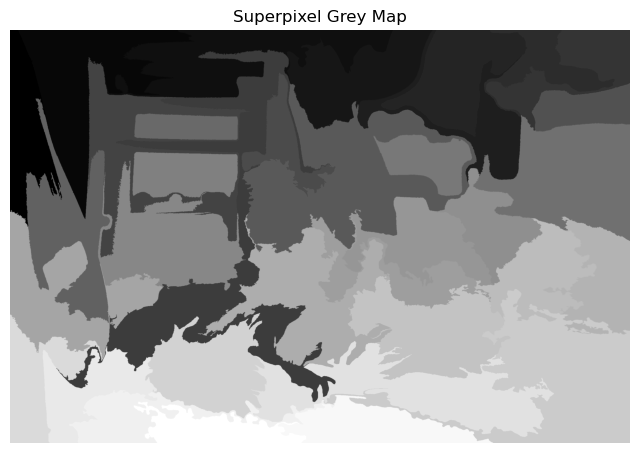

In [17]:
import scipy.ndimage as ndi
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Assume the following variables are available from the previous cells:
# - dog_guitar_np: The original image as a NumPy array
# - explanation_masks: List of tuples (label, prob, idx, mask) for the top-3 predictions
# - The 'segments' variable is not directly available in the previous cell, so we need to recompute it

# Step 1: Recompute the superpixel segmentation (since 'segments' isn't stored)
n_segments = 50  # Same as used in explain_instance_for_class
segments = slic(dog_guitar_np, n_segments=n_segments, compactness=10, sigma=1, start_label=0)

# Step 2: Strengthen Boundary Lines for Each Explanation Mask
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

# Original image
axes[0].imshow(dog_guitar_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Process each explanation mask
for i, (label, prob, idx, mask) in enumerate(explanation_masks, start=1):
    # Compute boundaries of the mask
    boundaries = find_boundaries(mask.astype(int), mode='outer')
    
    # Dilate the boundaries to make them thicker (using a 5x5 structure for thicker lines)
    thick_boundaries = ndi.binary_dilation(boundaries, structure=np.ones((5, 5)))
    
    # Create an overlay on a copy of the original image
    overlay_img = dog_guitar_np.copy()
    overlay_img[thick_boundaries] = [255, 0, 0]  # Set boundary pixels to red (RGB: 255, 0, 0)
    
    # Display the image with thickened boundaries
    axes[i].imshow(overlay_img)
    axes[i].set_title(f"Explaining '{label}' (p={prob:.2f})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Step 3: Create a Superpixel Grey Map
# Normalize the segmentation labels to range [0, 1] for display
grey_map = segments.astype(float)
grey_map = (grey_map - grey_map.min()) / (grey_map.max() - grey_map.min())

# Visualize the superpixel grey map
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(grey_map, cmap="gray")
ax.set_title("Superpixel Grey Map")
ax.axis("off")
plt.show()